# Laboratorium 6 - rekomendacje grafowe

## Przygotowanie

 * pobierz i wypakuj dataset `movies_graph.zip`
   * dane źródłowe: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data
   * więcej o przekształceniach i filtrowaniu możesz poczytać w notebooku `movies_graph_data_preparation.ipynb`
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install pykeen torch tqdm seaborn`

## Część 1. - przygotowanie danych

In [1]:
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [2]:
from ast import literal_eval
import csv
import numpy as np
from typing import List, Dict, Tuple
from random import shuffle

import tqdm as notebook_tqdm
import torch
from pykeen.models import ERModel, TransE
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory
import pandas as pd

INFO:pykeen.utils:Using opt_einsum


In [3]:
PATH = 'movies_graph'
TRAIN_DATA_RATIO = 0.9

In [4]:
# dataclasses

class Movie:
    def __init__(self,
                 movie_id: str,
                 title: str,
                 genres: List[str],
                 production_countries: List[str],
                 collection_name: str,
                 release_year: str):
        self.movie_id = movie_id
        self.title = title
        self.genres = genres
        self.production_countries = production_countries
        self.collection_name = collection_name
        self.release_year = release_year

    def add_cast(self,
                 actors: List[str],
                 directors: List[str],
                 screenwriters: List[str],
                 music_composers: List[str]):
        self.actors = actors
        self.directors = directors
        self.screenwriters = screenwriters
        self.music_composers = music_composers

    def basic_info(self):
        return {
            'movie_id': self.movie_id,
            'title': self.title,
            'genres': self.genres,
            'production_countries': self.production_countries
        }

    def __str__(self):
        return str(vars(self))

    def __repr__(self):
        return self.__str__()


class Review:
    def __init__(self, user_id: str, movie_id: str, rating: str):
        self.user_id = user_id
        self.movie_id = movie_id
        self.rating = float(rating)

    def __str__(self):
        return str(vars(self))

    def __repr__(self):
        return self.__str__()

In [5]:
# wczytujemy oceny filmow
with open('movies_graph/reviews.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    ratings = []
    for entry in list(reader):
        user_id, movie_id, rating = entry
        ratings.append(Review(f'u_{user_id}', f'm_{movie_id}', rating))

# podzial na zbior treningowy i testowy
shuffle(ratings)
train_ratings = ratings[:int(len(ratings)*TRAIN_DATA_RATIO)]
test_ratings = ratings[len(train_ratings):]
train_ratings

[{'user_id': 'u_242', 'movie_id': 'm_1299', 'rating': 5.0},
 {'user_id': 'u_387', 'movie_id': 'm_933', 'rating': 4.0},
 {'user_id': 'u_187', 'movie_id': 'm_7153', 'rating': 1.0},
 {'user_id': 'u_215', 'movie_id': 'm_924', 'rating': 5.0},
 {'user_id': 'u_543', 'movie_id': 'm_1', 'rating': 5.0},
 {'user_id': 'u_110', 'movie_id': 'm_45', 'rating': 5.0},
 {'user_id': 'u_273', 'movie_id': 'm_73017', 'rating': 4.0},
 {'user_id': 'u_497', 'movie_id': 'm_2145', 'rating': 4.0},
 {'user_id': 'u_489', 'movie_id': 'm_1246', 'rating': 4.0},
 {'user_id': 'u_242', 'movie_id': 'm_648', 'rating': 4.0},
 {'user_id': 'u_435', 'movie_id': 'm_593', 'rating': 4.0},
 {'user_id': 'u_125', 'movie_id': 'm_1732', 'rating': 5.0},
 {'user_id': 'u_615', 'movie_id': 'm_4993', 'rating': 3.0},
 {'user_id': 'u_373', 'movie_id': 'm_2303', 'rating': 4.0},
 {'user_id': 'u_664', 'movie_id': 'm_1639', 'rating': 3.0},
 {'user_id': 'u_627', 'movie_id': 'm_539', 'rating': 1.0},
 {'user_id': 'u_550', 'movie_id': 'm_2912', 'rati

In [6]:
# wczytujemy metadane filmow
def parse_movie_metadata(entry: List[str]):
    movie_id, title, genres, production_countries, collection_name, release_year = entry
    return Movie(f'm_{movie_id}', title, literal_eval(genres), literal_eval(production_countries), collection_name, release_year)

def add_cast_to_movie(movie: Movie, entry: List[str]):
    _movie_id, actors, directors, screenwriters, music_composers = entry
    movie.add_cast(literal_eval(actors), literal_eval(directors), literal_eval(screenwriters), literal_eval(music_composers))

with open('movies_graph/metadata.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    movies = {f'm_{entry[0]}': parse_movie_metadata(entry) for entry in reader}

with open('movies_graph/credits.csv') as f:
    reader = csv.reader(f)
    header = next(reader)
    for entry in reader:
        movie_id = f'm_{entry[0]}'
        add_cast_to_movie(movies[movie_id], entry)

movies

{'m_949': {'movie_id': 'm_949', 'title': 'Heat', 'genres': ['Action', 'Crime', 'Drama', 'Thriller'], 'production_countries': ['US'], 'collection_name': '', 'release_year': '1995', 'actors': ['Al Pacino', 'Robert De Niro', 'Val Kilmer', 'Jon Voight', 'Tom Sizemore', 'Diane Venora', 'Amy Brenneman', 'Ashley Judd', 'Mykelti Williamson', 'Natalie Portman', 'Ted Levine', 'Tom Noonan', 'Tone Loc', 'Hank Azaria', 'Wes Studi', 'Dennis Haysbert', 'Danny Trejo', 'Henry Rollins', 'William Fichtner', 'Kevin Gage', 'Susan Traylor', 'Jerry Trimble', 'Ricky Harris', 'Jeremy Piven', 'Xander Berkeley', 'Begonya Plaza', 'Rick Avery', 'Hazelle Goodman', 'Ray Buktenica', 'Max Daniels', 'Vince Deadrick Jr.', 'Steven Ford', 'Farrah Forke', 'Patricia Healy', 'Paul Herman', 'Cindy Katz', 'Brian Libby', 'Dan Martin', 'Mario Roberts', 'Thomas Rosales, Jr.', 'Yvonne Zima', 'Mick Gould', 'Bud Cort', 'Viviane Vives', 'Kim Staunton', 'Martin Ferrero', 'Brad Baldridge', 'Andrew Camuccio', 'Kenny Endoso', 'Kimberly F

## Część 2. - zbudowanie zbioru relacji

In [7]:
# generujemy dane dla modelu w formacie (head, relation, tail)
# na start mozesz uzyc malego podzbioru relacji, np. tylko 'positive_rating'

all_relation_types = [
    'positive_rating',
    'neutral_rating',
    'negative_rating',
    'genre',
    'production_country',
    'in_collection',
    'release_year',
    'actor_in',
    'director_of',
    'screenwriter_of',
    'composer_of'
]
basic_relation_types = [
    'positive_rating',
    'negative_rating'
]

def generate_triples(reviews: List[Review], movies: Dict[str, Movie], relation_types: List[str]) -> List[Tuple[str, str, str]]:
    triples = []
    for review in reviews:
        if 'positive_rating' in relation_types and review.rating >= 4.0:
            triples.append((review.user_id, 'positive_rating', review.movie_id))
        if 'negative_rating' in relation_types and review.rating < 3.0:
            triples.append((review.user_id, 'negative_rating', review.movie_id))

    return triples

triples = generate_triples(ratings, movies, basic_relation_types)
tf = TriplesFactory.from_labeled_triples(np.array(triples))

## Część 3. - trening modelu

In [8]:
def train_model(triples: List[Tuple[str, str, str]], tf: TriplesFactory):
    # tworzymy obiekt pomocniczy do reprezentacji zbioru danych
    training, testing, validation = tf.split([.8, .1, .1])

    # fix dla niektorych makow
    # mps_device = torch.device("mps")

    # zasadnicza czesc treningu
    pipeline_result = pipeline(
        # device=mps_device,
        training=training,
        testing=testing,
        validation=validation,
        model=TransE, # to najszybszy i najprostszy, ale i najslabszy model
        epochs=10 # to tylko przykladowa wartosc, na podstawie loss plot ocenimy, czy wystarczy
    )
    return pipeline_result

pipeline_result = train_model(triples, tf)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [42530, 5619, 5620]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/176 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/5.62k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 21.84s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

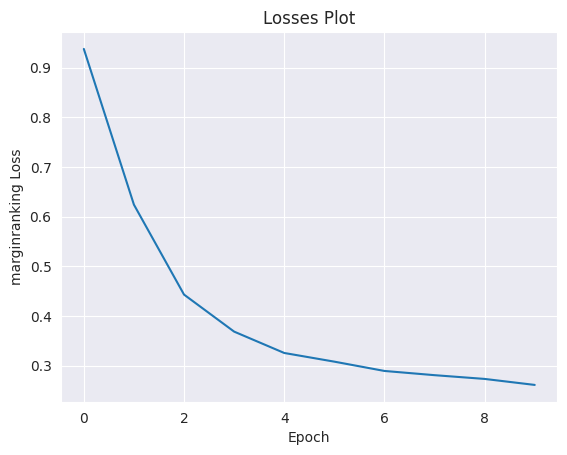

In [9]:
# wykres loss function
pipeline_result.plot_losses()

## Część 4. - rekomendacje

In [10]:
# funkcje pomocnicze
def print_movies(movie_ids: List[str], movies: Dict[str, Movie], print_missing=True):
    for m_id in movie_ids:
        if m_id in movies:
            print(movies[m_id].basic_info())
        elif print_missing:
            print(f'movie_id: {m_id}')

def describe_user(user_id: str, reviews: List[Review], movies: Dict[str, Movie]):
    positive_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating >= 4.0]
    negative_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating <= 2.0]
    neutral_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating > 2.0 and x.rating < 4.0]

    print(f'user_id: {user_id}')
    print('Positive ratings:')
    print_movies(positive_ratings, movies, print_missing=False)
    print('Neutral ratings:')
    print_movies(neutral_ratings, movies, print_missing=False)
    print('Negative ratings:')
    print_movies(negative_ratings, movies, print_missing=False)

In [11]:
def recommend(user_id: str, model: ERModel, triples_factory: TriplesFactory, k: int) -> List[str]:
    relation = 'positive_rating'
    prediction = predict_target(model, head=user_id, relation=relation, triples_factory=triples_factory)
    sorted_predictions = prediction.df.sort_values(by='score', ascending=False)
    # wygeneruj rekomendacje na podstawie predykcji
    recommended_movie_ids = sorted_predictions.head(k)['tail_label'].tolist()
    return recommended_movie_ids

In [14]:
# user_id = 'u_547' # uzytkownik z bardzo duza historia
user_id = 'u_244'
describe_user(user_id, ratings, movies)
recommendation = recommend(user_id, pipeline_result.model, tf, 20)
print('Recommendation:')
# print_recommendation(recommendation, movies)
print(recommendation)

user_id: u_244
Positive ratings:
{'movie_id': 'm_1376', 'title': 'Sweet Sixteen', 'genres': ['Crime', 'Drama'], 'production_countries': ['GB']}
{'movie_id': 'm_2502', 'title': 'The Bourne Supremacy', 'genres': ['Action', 'Drama', 'Thriller'], 'production_countries': ['DE', 'US']}
{'movie_id': 'm_1374', 'title': 'Rocky IV', 'genres': ['Drama'], 'production_countries': ['US']}
{'movie_id': 'm_527', 'title': 'Once Were Warriors', 'genres': ['Drama'], 'production_countries': ['NZ']}
{'movie_id': 'm_54272', 'title': '座頭市関所破り', 'genres': ['Adventure', 'Action', 'Drama'], 'production_countries': ['JP']}
{'movie_id': 'm_4886', 'title': 'And Then There Were None', 'genres': ['Crime', 'Drama', 'Mystery'], 'production_countries': ['US']}
{'movie_id': 'm_54503', 'title': 'Shuang ma lian huan', 'genres': ['Action', 'Foreign'], 'production_countries': ['HK', 'TW']}
{'movie_id': 'm_4993', 'title': '5 Card Stud', 'genres': ['Action', 'Western', 'Thriller'], 'production_countries': ['US']}
{'movie_id':

## Część 5. - metryki

In [15]:
# HitRatio@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy, czy oceniony film znalazl sie w rekomendacji
# zwracamy stosunek liczby trafien do liczby wszystkich prob

# wersja nieco bardziej zaawansowana - zamiast rekomendacji wyciagamy z modelu predykcje konkretnej relacji
# i liczymy skutecznosc w przewidywaniu, czy ocena byla pozytywna, negatywna czy neutralna

def hit_ratio(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int) -> float:
    hits = 0
    total = 0

    for review in test_ratings:
        if review.rating >= 4.0:
            total += 1
            user_id = review.user_id
            recommendation = recommend(user_id, model, tf, k)
            if review.movie_id in recommendation:
                hits += 1

    return hits / total if total else 0.0

hit_ratio(test_ratings, pipeline_result.model, tf, 50)

0.15510486287162942

In [17]:
# AvgPosition@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy, czy oceniony film znalazl sie w rekomendacji
# jesli tak, zapisujemy pozycje, na ktorej zarekomendowano film
# zwracamy srednia pozycje, na ktorych wystepowaly filmy

def avg_position(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int) -> float:
    total_position = 0
    count = 0

    for review in test_ratings:
        if review.rating >= 4.0:
            user_id = review.user_id
            recommendation = recommend(user_id, model, tf, k)
            if review.movie_id in recommendation:
                position = recommendation.index(review.movie_id) + 1
                total_position += position
                count += 1


    return total_position / count if count else 0.0

avg_position(test_ratings, pipeline_result.model, tf, 50)

22.13967310549777

## Część 5. - porównanie modeli

Wytrenowaliśmy podstawowy model, umiemy wygenerować rekomendacje i ocenić jakość modelu. Teraz przeanalizujemy, jakie zmiany mogą pozytywnie wpłynąć na jakość rekomendacji.

Porównaj bazowy model (np. TransH wytrenowany tylko na relacjach `positive_rating` i `negative_rating`) z dwoma innymi podejściami. Wybierz dwie spośród poniszych modyfikacji lub zaproponuj własną:
1. Zmiana modelu - zamiast TransH możesz użyć np. TransR albo RESCAL
2. Dodanie większej liczby typów relacji - możesz dodać oceny neutralne, metadane filmu, informacje o obsadzie. Nawet jeśli jakaś relacja nie jest wykorzystywana w procesie rekomendacji, może poprawić jakość wytrenowanego modelu. Zwróć uwagę, by jako rekoemndację zwracać wyłącznie identyfikatory filmów, nie innych wierzchołków.
3. Zmiana sposobu rekomendacji - obecny tryb opiera się na przewidywaniu relacji `positive_rating`. Możesz poprawić ten proces przez np. odsiewanie tych kandydatów, którzy występują także w predykcji relacji `negative_rating` czy filtrowanie kandydatów po metadanych (np. gatunku).

Porównanie trzech modeli oprzyj na dwóch zdefiniowanych w Części 4. metrykach dla wybranej wartości `k`.

In [ ]:
raise NotImplementedError()